# Minimal Transformer: Next Token Prediction

In this notebook, we build a minimal decoder-only transformer architecture (similar to GPT) and train it on next token prediction. This follows your previous class on attention mechanisms.

**Key differences from encoder-decoder transformers:**
- Decoder-only architecture (no encoder)
- Causal self-attention (can only attend to previous tokens)
- Next token prediction objective
- Character-level tokenization for simplicity

## Setup

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import math
import urllib.request
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
print(f'PyTorch version: {torch.__version__}')

Using device: cuda
PyTorch version: 2.5.1+cu121


## Configuration

We keep the model small so it can train quickly in Colab.

In [28]:
# Model hyperparameters
class Config:
    # Model architecture
    d_model = 128          # Embedding dimension
    n_heads = 4            # Number of attention heads
    n_layers = 4           # Number of transformer blocks
    d_ff = 512             # Feed-forward dimension
    dropout = 0.1          # Dropout rate

    # Training
    block_size = 64        # Maximum context length
    batch_size = 64        # Batch size
    learning_rate = 3e-4   # Learning rate
    max_iters = 3000       # Training iterations
    eval_interval = 300    # Evaluate every N iterations
    eval_iters = 100       # Number of iterations for evaluation

config = Config()

## Data: Choose Your Dataset

Select one of the following datasets by uncommenting the corresponding option.

In [29]:
# ============================================================
# OPTION 1: TinyStories (Recommended - Modern, Simple English)
# ============================================================
# # Download a subset of TinyStories dataset
# print("Downloading TinyStories dataset...")
# url = 'https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStoriesV2-GPT4-train.txt'
# urllib.request.urlretrieve(url, 'dataset.txt')

# # Read only first ~1MB (similar to Shakespeare size)
# with open('dataset.txt', 'r', encoding='utf-8') as f:
#     text = f.read(1_000_000)  # Read first 1 million characters

# print(f'Dataset length: {len(text):,} characters')
# print(f'\nFirst 500 characters:')
# print(text[:500])

In [30]:
# ============================================================
# OPTION 2: Shakespeare (Classic - Early Modern English)
# ============================================================
# Uncomment these lines to use Shakespeare instead:

# print("Downloading Shakespeare dataset...")
# url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
# urllib.request.urlretrieve(url, 'dataset.txt')
#
# with open('dataset.txt', 'r', encoding='utf-8') as f:
#     text = f.read()
#
# print(f'Dataset length: {len(text):,} characters')
# print(f'\nFirst 500 characters:')
# print(text[:500])

In [31]:
# ============================================================
# OPTION 3: Python Code
# ============================================================
# Uncomment these lines to train on Python code:

print("Downloading Python code dataset...")
url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/linux/input.txt'
urllib.request.urlretrieve(url, 'dataset.txt')

with open('dataset.txt', 'r', encoding='utf-8') as f:
    text = f.read(1_000_000)  # Read first 1 million characters

print(f'Dataset length: {len(text):,} characters')
print(f'\nFirst 500 characters:')
print(text[:500])

HTTPError: HTTP Error 404: Not Found

In [ ]:
# ============================================================
# OPTION 4: Modern Novel (e.g., The Adventures of Sherlock Holmes)
# ============================================================
# Uncomment these lines to use Sherlock Holmes:

# print("Downloading Sherlock Holmes...")
# url = 'https://www.gutenberg.org/files/1661/1661-0.txt'
# urllib.request.urlretrieve(url, 'dataset.txt')
#
# with open('dataset.txt', 'r', encoding='utf-8') as f:
#     text = f.read()
#
# # Remove Project Gutenberg header/footer
# start = text.find('I.')
# end = text.find('End of the Project Gutenberg')
# if start != -1 and end != -1:
#     text = text[start:end]
#
# print(f'Dataset length: {len(text):,} characters')
# print(f'\nFirst 500 characters:')
# print(text[:500])

In [ ]:
# ============================================================
# OPTION 5: Wikipedia Article (Simple English Wikipedia)
# ============================================================
# Uncomment these lines to use Wikipedia:

# print("Downloading Wikipedia dump...")
# # This is a small subset of Simple English Wikipedia
# url = 'https://dumps.wikimedia.org/simplewiki/latest/simplewiki-latest-pages-articles.xml.bz2'
# # Note: This requires additional processing with packages like mwparserfromhell
# # For simplicity, you might want to manually download a few Wikipedia articles as .txt
# # Or use a pre-processed Wikipedia dataset
#
# # For a quick demo, here's a manual approach:
# text = """Wikipedia is a free online encyclopedia.
# [Paste several Wikipedia articles here as plain text]
# """
#
# print(f'Dataset length: {len(text):,} characters')

## Character-Level Tokenization

For simplicity, we use character-level tokenization. Each unique character becomes a token.

In [ ]:
# Build vocabulary
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f'Vocabulary size: {vocab_size} unique characters')
print(f'Characters: {"".join(chars)}')

# Create character-to-integer and integer-to-character mappings
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

# Encoder: string -> list of integers
def encode(s):
    return [char_to_idx[c] for c in s]

# Decoder: list of integers -> string
def decode(ids):
    return ''.join([idx_to_char[i] for i in ids])

# Test
test_str = "Hello, world!"
encoded = encode(test_str)
decoded = decode(encoded)
print(f'\nOriginal: {test_str}')
print(f'Encoded: {encoded}')
print(f'Decoded: {decoded}')

Vocabulary size: 76 unique characters
Characters: 
 !"',-.01389:;<>?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz|–—’“”

Original: Hello, world!
Encoded: [25, 48, 55, 55, 58, 5, 1, 66, 58, 61, 55, 47, 2]
Decoded: Hello, world!


## Prepare Training Data

Split into train and validation sets.

In [ ]:
# Encode the entire dataset
data = torch.tensor(encode(text), dtype=torch.long)
print(f'Encoded data shape: {data.shape}')

# Train/validation split (90/10)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

print(f'Train data: {len(train_data):,} tokens')
print(f'Val data: {len(val_data):,} tokens')

Encoded data shape: torch.Size([1000000])
Train data: 900,000 tokens
Val data: 100,000 tokens


## Data Batching

Create batches of sequences for training. Each sequence is `block_size` tokens long.

In [ ]:
def get_batch(split, config):
    """
    Generate a small batch of data of inputs x and targets y.

    Args:
        split: 'train' or 'val'
        config: Configuration object

    Returns:
        x: Input sequences [batch_size, block_size]
        y: Target sequences [batch_size, block_size]
    """
    data = train_data if split == 'train' else val_data

    # Randomly select starting positions
    ix = torch.randint(len(data) - config.block_size, (config.batch_size,))

    # Create input and target sequences
    x = torch.stack([data[i:i+config.block_size] for i in ix])
    y = torch.stack([data[i+1:i+config.block_size+1] for i in ix])

    x, y = x.to(device), y.to(device)
    return x, y

# Test batch generation
x_batch, y_batch = get_batch('train', config)
print(f'Input batch shape: {x_batch.shape}')
print(f'Target batch shape: {y_batch.shape}')
print(f'\nExample sequence:')
print(f'Input:  {decode(x_batch[0].tolist())}')
print(f'Target: {decode(y_batch[0].tolist())}')

Input batch shape: torch.Size([64, 64])
Target batch shape: torch.Size([64, 64])

Example sequence:
Input:  kly. They said, "We are sorry, guard. We just wanted to see the 
Target: ly. They said, "We are sorry, guard. We just wanted to see the b


## Model Components

Now we build the transformer architecture from scratch.

### 1. Multi-Head Attention

You've already learned about attention! This is the causal (masked) version.

In [ ]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head causal self-attention.

    Key difference from your previous class:
    - Uses a causal mask to prevent attending to future tokens
    """

    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads  # Dimension per head

        # Linear projections for Q, K, V (all heads at once)
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)

        # Output projection
        self.W_o = nn.Linear(d_model, d_model, bias=False)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Args:
            x: Input tensor [batch_size, seq_len, d_model]

        Returns:
            Output tensor [batch_size, seq_len, d_model]
        """
        batch_size, seq_len, d_model = x.shape

        # Linear projections
        Q = self.W_q(x)  # [batch_size, seq_len, d_model]
        K = self.W_k(x)
        V = self.W_v(x)

        # Split into multiple heads and reshape
        # [batch_size, seq_len, d_model] -> [batch_size, seq_len, n_heads, d_k]
        # -> [batch_size, n_heads, seq_len, d_k]
        Q = Q.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)

        # Scaled dot-product attention
        # Compute attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        # [batch_size, n_heads, seq_len, seq_len]

        # Apply causal mask (prevent attending to future tokens)
        mask = torch.tril(torch.ones(seq_len, seq_len, device=x.device)).bool()
        scores = scores.masked_fill(~mask, float('-inf'))

        # Apply softmax
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Apply attention to values
        out = torch.matmul(attn_weights, V)
        # [batch_size, n_heads, seq_len, d_k]

        # Concatenate heads
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)

        # Output projection
        out = self.W_o(out)

        return out

### 2. Feed-Forward Network

In [ ]:
class FeedForward(nn.Module):
    """
    Position-wise Feed-Forward Network.
    Two linear transformations with GELU activation.
    """

    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

### 3. Transformer Block

Combines attention and feed-forward with residual connections and layer normalization.

In [ ]:
class TransformerBlock(nn.Module):
    """
    A single transformer block:
    - Multi-head attention with residual connection
    - Feed-forward network with residual connection
    - Layer normalization (pre-norm architecture)
    """

    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.ln2 = nn.LayerNorm(d_model)
        self.ff = FeedForward(d_model, d_ff, dropout)

    def forward(self, x):
        # Pre-norm architecture (more stable training)
        # Attention with residual
        x = x + self.attn(self.ln1(x))
        # Feed-forward with residual
        x = x + self.ff(self.ln2(x))
        return x

### 4. Complete Transformer Model

In [ ]:
class GPTModel(nn.Module):
    """
    A minimal GPT-style transformer for next token prediction.

    Architecture:
    1. Token embeddings + positional embeddings
    2. Stack of transformer blocks
    3. Layer norm
    4. Linear head to predict next token
    """

    def __init__(self, vocab_size, config):
        super().__init__()
        self.config = config

        # Token embeddings
        self.token_embedding = nn.Embedding(vocab_size, config.d_model)

        # Positional embeddings (learned)
        self.pos_embedding = nn.Embedding(config.block_size, config.d_model)

        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(config.d_model, config.n_heads, config.d_ff, config.dropout)
            for _ in range(config.n_layers)
        ])

        # Final layer norm
        self.ln_f = nn.LayerNorm(config.d_model)

        # Language modeling head
        self.lm_head = nn.Linear(config.d_model, vocab_size, bias=False)

        # Weight tying (share weights between token embeddings and lm_head)
        self.token_embedding.weight = self.lm_head.weight

        # Initialize weights
        self.apply(self._init_weights)

        # Report number of parameters
        n_params = sum(p.numel() for p in self.parameters())
        print(f"Number of parameters: {n_params/1e6:.2f}M")

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        """
        Args:
            idx: Input token indices [batch_size, seq_len]
            targets: Target token indices [batch_size, seq_len] (optional)

        Returns:
            logits: Output logits [batch_size, seq_len, vocab_size]
            loss: Cross-entropy loss (if targets provided)
        """
        batch_size, seq_len = idx.shape

        # Token embeddings
        tok_emb = self.token_embedding(idx)  # [batch_size, seq_len, d_model]

        # Positional embeddings
        pos = torch.arange(0, seq_len, dtype=torch.long, device=idx.device)
        pos_emb = self.pos_embedding(pos)  # [seq_len, d_model]

        # Add embeddings
        x = tok_emb + pos_emb  # Broadcasting happens automatically

        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)

        # Final layer norm
        x = self.ln_f(x)

        # Language modeling head
        logits = self.lm_head(x)  # [batch_size, seq_len, vocab_size]

        # Compute loss if targets are provided
        loss = None
        if targets is not None:
            # Reshape for cross-entropy
            B, T, C = logits.shape
            logits_flat = logits.view(B * T, C)
            targets_flat = targets.view(B * T)
            loss = F.cross_entropy(logits_flat, targets_flat)

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate new tokens autoregressively.

        Args:
            idx: Starting sequence [batch_size, seq_len]
            max_new_tokens: Number of tokens to generate
            temperature: Sampling temperature (higher = more random)
            top_k: If set, only sample from top k tokens

        Returns:
            Generated sequence [batch_size, seq_len + max_new_tokens]
        """
        for _ in range(max_new_tokens):
            # Crop context if needed (to fit block_size)
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]

            # Forward pass
            logits, _ = self(idx_cond)

            # Focus on last time step
            logits = logits[:, -1, :] / temperature  # [batch_size, vocab_size]

            # Optionally crop logits to only top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')

            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)

            # Append to sequence
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

## Create Model Instance

In [ ]:
# Create model
model = GPTModel(vocab_size, config).to(device)

# Print model architecture
print(model)

Number of parameters: 0.81M
GPTModel(
  (token_embedding): Embedding(76, 128)
  (pos_embedding): Embedding(64, 128)
  (blocks): ModuleList(
    (0-3): 4 x TransformerBlock(
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=128, out_features=128, bias=False)
        (W_k): Linear(in_features=128, out_features=128, bias=False)
        (W_v): Linear(in_features=128, out_features=128, bias=False)
        (W_o): Linear(in_features=128, out_features=128, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ff): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=512, out_features=128, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (ln_f): LayerNorm((128,

## Training Setup

In [ ]:
# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

@torch.no_grad()
def estimate_loss(model, config):
    """
    Estimate loss on train and validation sets.
    """
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(config.eval_iters)
        for k in range(config.eval_iters):
            X, Y = get_batch(split, config)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

## Test Generation Before Training

Let's see what the untrained model generates (should be gibberish).

In [ ]:
# Generate from untrained model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated = model.generate(context, max_new_tokens=200, temperature=1.0, top_k=10)
print('\n=== Untrained Model Generation ===')
print(decode(generated[0].tolist()))
print('=' * 50)


=== Untrained Model Generation ===

-d..—kS.—
.m!LLTidjj’mW.d.!mEQ!||8-dxLLm.Smj’L.m-ddKGWF".Q||x"||mmNNgdAmKW..|RFA?..m|FfcdwMMmdmL|FddE-Kf|FMWFKQ-WmLKjLM0.?d? .mmmmWm-9XX--dm|www3|LLdwQd.u|FK|u|dmJmQdmFWFc0dd|KKu3WW.W9d-mONWEuQmWhQ-dW


## Training Loop

Train for a few thousand iterations. Even this limited training should show improvement!

In [ ]:
# Training loop
train_losses = []
val_losses = []
iterations = []

print('Starting training...')
print(f'Training for {config.max_iters} iterations')
print(f'Evaluating every {config.eval_interval} iterations\n')

for iter in tqdm(range(config.max_iters)):
    # Evaluate loss periodically
    if iter % config.eval_interval == 0 or iter == config.max_iters - 1:
        losses = estimate_loss(model, config)
        print(f"Step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        iterations.append(iter)

    # Sample a batch
    xb, yb = get_batch('train', config)

    # Forward pass
    logits, loss = model(xb, yb)

    # Backward pass
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print('\nTraining complete!')

Starting training...
Training for 3000 iterations
Evaluating every 300 iterations



  0%|          | 0/3000 [00:00<?, ?it/s]

Step 0: train loss 4.3461, val loss 4.3455
Step 300: train loss 2.0661, val loss 2.0727
Step 600: train loss 1.6012, val loss 1.6109
Step 900: train loss 1.3933, val loss 1.3949
Step 1200: train loss 1.2643, val loss 1.2783
Step 1500: train loss 1.2021, val loss 1.2186
Step 1800: train loss 1.1445, val loss 1.1802
Step 2100: train loss 1.1004, val loss 1.1357
Step 2400: train loss 1.0762, val loss 1.1199
Step 2700: train loss 1.0440, val loss 1.0941
Step 2999: train loss 1.0301, val loss 1.0759

Training complete!


## Plot Training Progress

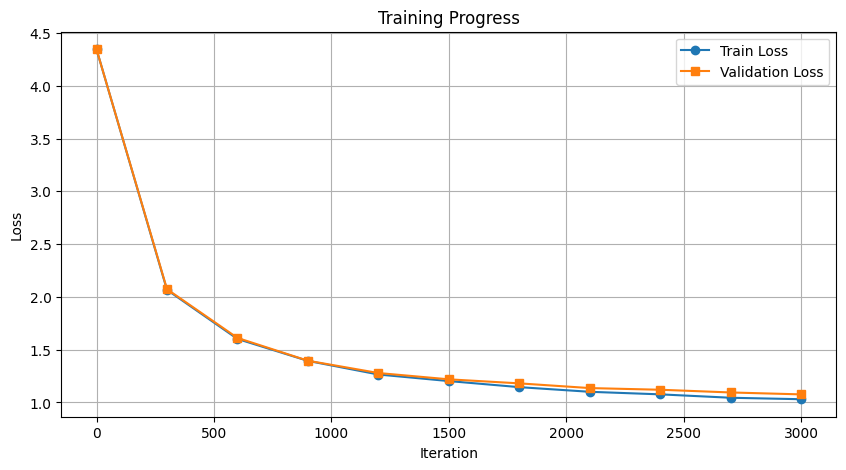

Initial train loss: 4.3461
Final train loss: 1.0301
Improvement: 3.3160


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(iterations, train_losses, label='Train Loss', marker='o')
plt.plot(iterations, val_losses, label='Validation Loss', marker='s')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.show()

print(f'Initial train loss: {train_losses[0]:.4f}')
print(f'Final train loss: {train_losses[-1]:.4f}')
print(f'Improvement: {train_losses[0] - train_losses[-1]:.4f}')

## Test Generation After Training

Now let's see what the trained model generates!

In [ ]:
# Generate from trained model
model.eval()
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated = model.generate(context, max_new_tokens=500, temperature=1.0, top_k=10)
print('\n=== Trained Model Generation ===')
print(decode(generated[0].tolist()))
print('=' * 50)


=== Trained Model Generation ===

<|endoftext|>
Once upon a time, there was a new lot. The boy was happy to help her help again. He wanted to be back the slow, but they licked his toys for that the san in the park on his toys. The duck who was to get it. She took it and blied up. One day, a cubilbing. She was time to give the dees in the tree was so shared her.
<|endoftext|>
One day, a little dog named Tim went to the house, Tim played with his nice. Emma decided to make and spicy fill her together.
<|endoftext|>
Once upon a toy


## Generation with Different Seeds

Try starting with different prompts. Adjust these based on your dataset!

In [ ]:
def generate_with_prompt(prompt, max_new_tokens=300, temperature=0.8, top_k=10):
    """
    Generate text starting from a prompt.
    """
    context = torch.tensor([encode(prompt)], dtype=torch.long, device=device)
    generated = model.generate(context, max_new_tokens=max_new_tokens,
                             temperature=temperature, top_k=top_k)
    return decode(generated[0].tolist())

# Choose prompts based on your dataset:

# For TinyStories:
prompts = [
    "Once upon a time",
    "One day, a little",
    "There was a",
    "The girl was"
]

# For Shakespeare:
# prompts = [
#     "ROMEO:\n",
#     "To be or not to be",
#     "First Citizen:\n",
#     "The king"
# ]

# For Python code:
# prompts = [
#     "def ",
#     "import ",
#     "class ",
#     "for i in"
# ]

# For Sherlock Holmes:
# prompts = [
#     "Sherlock Holmes",
#     "The detective",
#     "Watson said",
#     "It was a"
# ]

for prompt in prompts:
    print(f'\n=== Prompt: "{prompt}" ===')
    generated_text = generate_with_prompt(prompt, max_new_tokens=200)
    print(generated_text)
    print('=' * 50)


=== Prompt: "Once upon a time" ===
Once upon a time, there was a little named Sue. She liked to play in the pond and danger. He had a sure little ball in the weops a small tight. The see was still tree again, and they had a lot of flute. They liked to

=== Prompt: "One day, a little" ===
One day, a little girl named Miany. Ben loved to play with the park with her friends. Let's hee would man bag in the water and a came best friendly. They like they always time the big frog.
<|endoftext|>
One day, a li

=== Prompt: "There was a" ===
There was a tree was not safe.
"Lily asks, Sammy, and the dog!" The turtle bag and could the work. He said Sam.
The bird was very happy. It made the found a big tree and water. How took him to show together, the

=== Prompt: "The girl was" ===
The girl was a cat named Sue. She called Bybe wanted to help him.
<|endoftext|>
Once upon a time, there was a toy named Tim. Tim was surprised to go to the maght. He was very surprised. He asked her mome and what


## Temperature and Top-K Effects

Experiment with different generation parameters.

In [ ]:
# Choose a prompt from your dataset:
prompt = "Once upon a time"  # For TinyStories
# prompt = "ROMEO:\n"  # For Shakespeare
# prompt = "def "  # For Python code
# prompt = "Sherlock Holmes"  # For Sherlock Holmes

print("=== Low Temperature (0.5) - More focused ===")
print(generate_with_prompt(prompt, max_new_tokens=150, temperature=0.5, top_k=10))

print("\n=== Medium Temperature (1.0) - Balanced ===")
print(generate_with_prompt(prompt, max_new_tokens=150, temperature=1.0, top_k=10))

print("\n=== High Temperature (1.5) - More random ===")
print(generate_with_prompt(prompt, max_new_tokens=150, temperature=1.5, top_k=10))

=== Low Temperature (0.5) - More focused ===
Once upon a time, there was a started in the park. He loved to play with her family. He was so happy. He took the bird and said, "Thank you, we can me to get the stic

=== Medium Temperature (1.0) - Balanced ===
Once upon a time, there was a new friends.
The moral old man around him and happy.
The fly played, Tim found and her friends. They helped that they all cat had lots."

=== High Temperature (1.5) - More random ===
Once upon a time, there little g named Sue. She loved time a butterfly. The boy learded the sand.
Sue pecied, the tree day brave for thow. But thelpned talked, and so


## Analysis: What Did We Learn?

Even with this minimal training:
1. **Structure**: The model learns basic text structure (words, punctuation, capitalization)
2. **Patterns**: It picks up on common patterns in the data
   - TinyStories: narrative structure, character actions
   - Shakespeare: dialogue format, character names
   - Python code: syntax, indentation, function structure
3. **Context**: The causal attention allows it to use context from previous tokens
4. **Limitations**: It's not perfect - longer coherence requires much more training

**Key Architecture Points:**
- **Decoder-only**: Unlike encoder-decoder models for translation, this is decoder-only (like GPT)
- **Causal attention**: The mask ensures we only attend to past tokens
- **Next token prediction**: Simple but powerful objective
- **Scalability**: This same architecture scales to billions of parameters (GPT-3, GPT-4)

## Exercise

To improve this model further, try one or multiple of the following:
1. Train for more iterations (10k-50k)
2. Increase model size (more layers, larger d_model)
3. Combine datasets together to have more text (be careful of style differences)
4. Add learning rate scheduling
5. Modify the optimizer and hyperparameters
6. Implement gradient clipping
7. Try different tokenization (BPE instead of character-level)
8. Add dropout for better regularization
9. Experiment with different attention patterns (e.g., Flash Attention)

## Save Model (Optional)

In [ ]:
# Save model checkpoint
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'config': config,
    'vocab_size': vocab_size,
    'char_to_idx': char_to_idx,
    'idx_to_char': idx_to_char,
}, 'minimal_transformer_checkpoint.pt')

print('Model saved to minimal_transformer_checkpoint.pt')

Model saved to minimal_transformer_checkpoint.pt


## Summary

In this notebook, we built a minimal transformer from scratch:
- Character-level tokenization
- Causal multi-head attention
- Position-wise feed-forward networks
- Residual connections and layer normalization
- Next token prediction training
- Autoregressive generation

This architecture is the foundation of modern LLMs like GPT!

**Questions to consider:**
1. Why is causal masking necessary for language generation?
2. What would happen without positional embeddings?
3. How does temperature affect generation quality?
4. What are the tradeoffs between character-level and subword tokenization?